In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with= engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
#getting column names of each class
inspector = inspect(engine)
columns_m = inspector.get_columns('measurement')
for c in columns_m:
    print(c['name'], c["type"])

#printing divider for readability
print("___")
columns_s = inspector.get_columns('station')
for c in columns_s:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
___
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [8]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)

# Exploratory Precipitation Analysis

In [10]:
# Find the most recent date in the data set.
#queried by the measurement date, with pulling the top date while the measurement date is in descending order
session.query(measurement.date).order_by(measurement.date.desc()).first()

('2017-08-23',)

[]

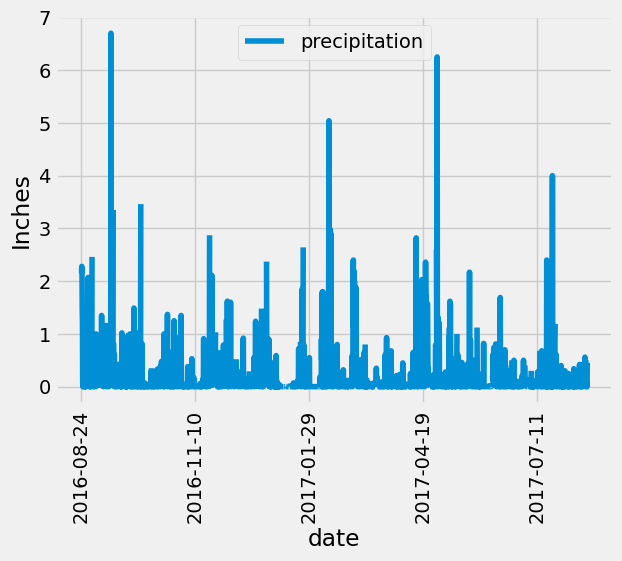

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
one_year_back = dt.datetime(2017,8,23) - dt.timedelta(days = 365)

# Perform a query to retrieve the data and precipitation scores
a_year_data = session.query(measurement.date, measurement.prcp).filter(measurement.date >= one_year_back).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
year_of_rain_df = pd.DataFrame(a_year_data, columns = ["date", "precipitation"])

# Sort the dataframe by date
# setting the index to date
year_of_rain_df = year_of_rain_df.sort_values(by = 'date')
year_of_rain_df.set_index('date',  inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
year_of_rain_df.plot(xlabel = 'date', ylabel='Inches', rot=90)
plt.plot()

In [12]:
# Use Pandas to calculate the summary statistics for the precipitation data
year_of_rain_df.describe()

,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [13]:
# Design a query to calculate the total number of stations in the dataset
#https://docs.sqlalchemy.org/en/20/core/functions.html for func.count() function

station_count = session.query(func.count(station.station)).all()
station_count

[(9,)]

In [14]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
sel = [measurement.station, func.count(measurement.date)]
active_stations = session.query(*sel).\
        group_by(measurement.station).\
        order_by(func.count(measurement.date).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [16]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active = "USC00519281"

# https://docs.sqlalchemy.org/en/20/core/functions.html for func.min() and func.max()
sel = [func.min(measurement.tobs),
       func.max(measurement.tobs),
       func.avg(measurement.tobs)]

#filter the query to only show avg, min, and max for most active station
most_active_station = session.query(*sel).\
       filter(measurement.station == most_active)

most_active_station[0]

(54.0, 85.0, 71.66378066378067)

[]

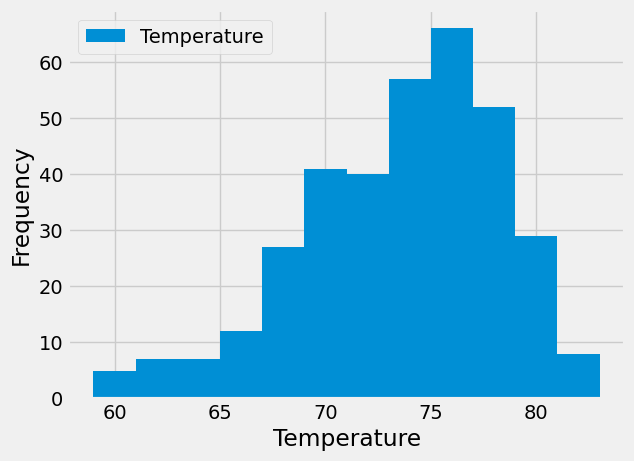

In [17]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
sel = [measurement.date, measurement.tobs]

#query the selection, filtering by dates from a year from the lastest date where the station has the id of the most active station
station_temp = session.query(*sel).\
    filter(measurement.date >= one_year_back, measurement.station == most_active)

# Save the query results as a Pandas DataFrame. Explicitly set the column names
station_temp_df = pd.DataFrame(station_temp, columns = ['Measurement Date', 'Temperature'])

# Sort the dataframe by date and setting the index to date
station_temp_df = station_temp_df.sort_values(by = 'Measurement Date')
station_temp_df.set_index('Measurement Date',  inplace=True)

station_temp_df.plot.hist(xlabel = 'temperature', ylabel='frequency', bins = 12)
plt.xlabel('Temperature')
plt.plot()
    

# Close Session

In [18]:
# Close Session
session.close()